In [1]:
%tensorflow_version 1.x

import tensorflow as tf
import numpy as np
from __future__ import print_function
from tensorflow.contrib.layers import batch_norm, fully_connected, flatten
from tensorflow.contrib.layers import xavier_initializer
from tensorflow.python.client import device_lib
from scipy.io import wavfile
import glob
import timeit
import os
import shutil
from contextlib import contextmanager

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('content')

Mounted at content


In [ ]:

class VBN(object):
    """
    Virtual Batch Normalization
    (modified from https://github.com/openai/improved-gan/ definition)
    """

    def __init__(self, x, name, epsilon=1e-5):
        """
        x is the reference batch
        """
        assert isinstance(epsilon, float)

        shape = x.get_shape().as_list()
        assert len(shape) == 3, shape
        with tf.variable_scope(name) as scope:
            assert name.startswith("d_") or name.startswith("g_")
            self.epsilon = epsilon
            self.name = name
            self.mean = tf.reduce_mean(x, [0, 1], keep_dims=True)
            self.mean_sq = tf.reduce_mean(tf.square(x), [0, 1], keep_dims=True)
            self.batch_size = int(x.get_shape()[0])
            assert x is not None
            assert self.mean is not None
            assert self.mean_sq is not None
            out = self._normalize(x, self.mean, self.mean_sq, "reference")
            self.reference_output = out

    def __call__(self, x):

        shape = x.get_shape().as_list()
        with tf.variable_scope(self.name) as scope:
            new_coeff = 1. / (self.batch_size + 1.)
            old_coeff = 1. - new_coeff
            new_mean = tf.reduce_mean(x, [0, 1], keep_dims=True)
            new_mean_sq = tf.reduce_mean(tf.square(x), [0, 1], keep_dims=True)
            mean = new_coeff * new_mean + old_coeff * self.mean
            mean_sq = new_coeff * new_mean_sq + old_coeff * self.mean_sq
            out = self._normalize(x, mean, mean_sq, "live")
            return out

    def _normalize(self, x, mean, mean_sq, message):
        # make sure this is called with a variable scope
        shape = x.get_shape().as_list()
        assert len(shape) == 3
        self.gamma = tf.get_variable("gamma", [shape[-1]],
                                initializer=tf.random_normal_initializer(1., 0.02))
        gamma = tf.reshape(self.gamma, [1, 1, -1])
        self.beta = tf.get_variable("beta", [shape[-1]],
                                initializer=tf.constant_initializer(0.))
        beta = tf.reshape(self.beta, [1, 1, -1])
        assert self.epsilon is not None
        assert mean_sq is not None
        assert mean is not None
        std = tf.sqrt(self.epsilon + mean_sq - tf.square(mean))
        out = x - mean
        out = out / std
        out = out * gamma
        out = out + beta
        return out

In [ ]:
def pre_emph(x, coeff=0.95):
    x0 = tf.reshape(x[0], [
        1,
    ])
    diff = x[1:] - coeff * x[:-1]
    concat = tf.concat([x0, diff], 0)
    return concat


def de_emph(y, coeff=0.95):
    if coeff <= 0:
        return y
    x = np.zeros(y.shape[0], dtype=np.float32)
    x[0] = y[0]
    for n in range(1, y.shape[0], 1):
        x[n] = coeff * x[n - 1] + y[n]
    return x

def read_and_decode(filename_queue, canvas_size, preemph=0.):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(
        serialized_example,
        features={
            'wav_raw': tf.FixedLenFeature([], tf.string),
            'noisy_raw': tf.FixedLenFeature([], tf.string),
        })
    wave = tf.decode_raw(features['wav_raw'], tf.int32)
    wave.set_shape(canvas_size)
    wave = (2. / 65535.) * tf.cast((wave - 32767), tf.float32) + 1.
    noisy = tf.decode_raw(features['noisy_raw'], tf.int32)
    noisy.set_shape(canvas_size)
    noisy = (2. / 65535.) * tf.cast((noisy - 32767), tf.float32) + 1.

    if preemph > 0:
        wave = tf.cast(pre_emph(wave, preemph), tf.float32)
        noisy = tf.cast(pre_emph(noisy, preemph), tf.float32)

    return wave, noisy

In [ ]:
def gaussian_noise_layer(input_layer, std):
    noise = tf.random_normal(
        shape=input_layer.get_shape().as_list(),
        mean=0.0,
        stddev=std,
        dtype=tf.float32)
    return input_layer + noise

# ?
def sample_random_walk(batch_size, dim):
    rw = np.zeros((batch_size, dim))
    rw[:, 0] = np.random.randn(batch_size)
    for b in range(batch_size):
        for di in range(1, dim):
            rw[b, di] = rw[b, di - 1] + np.random.randn(1)
    # normalize to m=0 std=1
    mean = np.mean(rw, axis=1).reshape((-1, 1))
    std = np.std(rw, axis=1).reshape((-1, 1))
    rw = (rw - mean) / std
    return rw

# scalar summary
def scalar_summary(name, x):
    try:
        summ = tf.summary.scalar(name, x)
    except AttributeError:
        summ = tf.summary.scalar(name, x)
    return summ

# histogram summary
def histogram_summary(name, x):
    try:
        summ = tf.summary.histogram(name, x)
    except AttributeError:
        summ = tf.summary.histogram(name, x)
    return summ

# tensor summary
def tensor_summary(name, x):
    try:
        summ = tf.summary.tensor_summary(name, x)
    except AttributeError:
        summ = tf.summary.tensor_summary(name, x)
    return summ

# audio summary
def audio_summary(name, x, sampling_rate=16e3):
    try:
        summ = tf.summary.audio(name, x, sampling_rate)
    except AttributeError:
        summ = tf.summary.audio(name, x, sampling_rate)
    return summ

# normalization
def minmax_normalize(x, x_min, x_max, o_min=-1., o_max=1.):
    return (o_max - o_min) / (x_max - x_min) * (x - x_max) + o_max

# denormalization
def minmax_denormalize(x, x_min, x_max, o_min=-1., o_max=1.):
    return minmax_normalize(x, o_min, o_max, x_min, x_max)

# convolution downsample
def downconv(x, output_dim, # out channels
             kwidth=5, pool=2,
             init=None,uniform=False,
             bias_init=None,name='downconv'):
    """ Downsampled convolution 1d """
    x2d = tf.expand_dims(x, 2) # expands height dim
    w_init = init
    if w_init is None:
        w_init = xavier_initializer(uniform=uniform) # using xavier_initializer
    with tf.variable_scope(name):
        W = tf.get_variable(
            'W', [kwidth, 1, x.get_shape()[-1], output_dim],
            initializer=w_init)
        conv = tf.nn.conv2d(x2d, W, strides=[1, pool, 1, 1], padding='SAME')
        if bias_init is not None:
            b = tf.get_variable('b', [output_dim], initializer=bias_init)
            conv = tf.reshape(tf.nn.bias_add(conv, b), conv.get_shape())
        else:
            conv = tf.reshape(conv, conv.get_shape())
        # reshape back to 1d
        conv = tf.reshape(
            conv,
            conv.get_shape().as_list()[:2] + [conv.get_shape().as_list()[-1]]) # remove the height dim
        return conv


# https://github.com/carpedm20/lstm-char-cnn-tensorflow/blob/master/models/ops.py
def highway(input_, size, layer_size=1, bias=-2, f=tf.nn.relu, name='hw'):
    """Highway Network (cf. http://arxiv.org/abs/1505.00387).
    t = sigmoid(Wy + b)
    z = t * g(Wy + b) + (1 - t) * y
    where g is nonlinearity, t is transform gate, and (1 - t) is carry gate.
    """
    output = input_
    for idx in range(layer_size):
        lin_scope = '{}_output_lin_{}'.format(name, idx)
        output = f(tf.contrib.rnn._linear(output, size, 0, scope=lin_scope))
        transform_scope = '{}_transform_lin_{}'.format(name, idx)
        transform_gate = tf.sigmoid(
            tf.contrib.rnn._linear(input_, size, 0, scope=transform_scope) +
            bias)
        carry_gate = 1. - transform_gate

        output = transform_gate * output + carry_gate * input_

    return output

def leakyrelu(x, alpha=0.3, name='lrelu'):
    return tf.maximum(x, alpha * x, name=name)

def prelu(x, name='prelu', ref=False):
    in_shape = x.get_shape().as_list()
    with tf.variable_scope(name):
        # make one alpha per feature
        alpha = tf.get_variable(
            'alpha',
            in_shape[-1],
            initializer=tf.constant_initializer(0.),
            dtype=tf.float32)
        pos = tf.nn.relu(x)
        neg = alpha * (x - tf.abs(x)) * .5
        if ref:
            # return ref to alpha vector
            return pos + neg, alpha
        else:
            return pos + neg


def conv1d(x, kwidth=5,
           num_kernels=1, init=None,
           uniform=False, bias_init=None,
           name='conv1d', padding='SAME'):
    input_shape = x.get_shape()
    in_channels = input_shape[-1]
    assert len(input_shape) >= 3
    w_init = init
    if w_init is None:
        w_init = xavier_initializer(uniform=uniform)
    with tf.variable_scope(name):
        # filter shape: [kwidth, in_channels, num_kernels]
        W = tf.get_variable(
            'W', [kwidth, in_channels, num_kernels], initializer=w_init)
        conv = tf.nn.conv1d(x, W, stride=1, padding=padding)
        if bias_init is not None:
            b = tf.get_variable(
                'b', [num_kernels],
                initializer=tf.constant_initializer(bias_init))
            conv = conv + b
        return conv

# https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
# used for dilated conv
def time_to_batch(value, dilation, name=None):
    with tf.name_scope('time_to_batch'):
        shape = tf.shape(value)
        pad_elements = dilation - 1 - (shape[1] + dilation - 1) % dilation
        padded = tf.pad(value, [[0, 0], [0, pad_elements], [0, 0]])
        reshaped = tf.reshape(padded, [-1, dilation, shape[2]])
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        return tf.reshape(transposed, [shape[0] * dilation, -1, shape[2]])

# used for dilated conv
# https://github.com/ibab/tensorflow-wavenet/blob/master/wavenet/ops.py
def batch_to_time(value, dilation, name=None):
    with tf.name_scope('batch_to_time'):
        shape = tf.shape(value)
        prepared = tf.reshape(value, [dilation, -1, shape[2]])
        transposed = tf.transpose(prepared, perm=[1, 0, 2])
        return tf.reshape(transposed,
                          [tf.div(shape[0], dilation), -1, shape[2]])

# dilated convolution
def atrous_conv1d(value,
                  dilation,
                  kwidth=3,
                  num_kernels=1,
                  name='atrous_conv1d',
                  bias_init=None,
                  stddev=0.02):
    input_shape = value.get_shape().as_list()
    in_channels = input_shape[-1]
    assert len(input_shape) >= 3
    with tf.variable_scope(name):
        weights_init = tf.truncated_normal_initializer(stddev=0.02)
        # filter shape: [kwidth, in_channels, output_channels]
        filter_ = tf.get_variable(
            'w',
            [kwidth, in_channels, num_kernels],
            initializer=weights_init,
        )
        padding = [[0, 0], [(kwidth / 2) * dilation, (kwidth / 2) * dilation],
                   [0, 0]]
        padded = tf.pad(value, padding, mode='SYMMETRIC')
        if dilation > 1:
            transformed = time_to_batch(padded, dilation)
            conv = tf.nn.conv1d(transformed, filter_, stride=1, padding='SAME')
            restored = batch_to_time(conv, dilation)
        else:
            restored = tf.nn.conv1d(padded, filter_, stride=1, padding='SAME')
        # Remove excess elements at the end.
        result = tf.slice(restored, [0, 0, 0],
                          [-1, input_shape[1], num_kernels])
        if bias_init is not None:
            b = tf.get_variable(
                'b', [num_kernels],
                initializer=tf.constant_initializer(bias_init))
            result = tf.add(result, b)
        return result

def residual_block(input_,
                   dilation,
                   kwidth,
                   num_kernels=1,
                   bias_init=None,
                   stddev=0.02,
                   do_skip=True,
                   name='residual_block'):
    print('input shape to residual block: ', input_.get_shape())
    with tf.variable_scope(name):
        h_a = atrous_conv1d(
            input_,
            dilation,
            kwidth,
            num_kernels,
            bias_init=bias_init,
            stddev=stddev)
        h = tf.tanh(h_a)
        # apply gated activation
        z_a = atrous_conv1d(
            input_,
            dilation,
            kwidth,
            num_kernels,
            name='conv_gate',
            bias_init=bias_init,
            stddev=stddev)
        z = tf.nn.sigmoid(z_a)
        print('gate shape: ', z.get_shape())
        # element-wise apply the gate
        gated_h = tf.multiply(z, h)
        print('gated h shape: ', gated_h.get_shape())
        #make res connection
        h_ = conv1d(
            gated_h,
            kwidth=1,
            num_kernels=1,
            init=tf.truncated_normal_initializer(stddev=stddev),
            name='residual_conv1')
        res = h_ + input_
        print('residual result: ', res.get_shape())
        if do_skip:
            #make skip connection
            skip = conv1d(
                gated_h,
                kwidth=1,
                num_kernels=1,
                init=tf.truncated_normal_initializer(stddev=stddev),
                name='skip_conv1')
            return res, skip
        else:
            return res


# Code from keras backend
# https://github.com/fchollet/keras/blob/master/keras/backend/tensorflow_backend.py
def repeat_elements(x, rep, axis):
    """Repeats the elements of a tensor along an axis, like `np.repeat`.
    If `x` has shape `(s1, s2, s3)` and `axis` is `1`, the output
    will have shape `(s1, s2 * rep, s3)`.
    # Arguments
        x: Tensor or variable.
        rep: Python integer, number of times to repeat.
        axis: Axis along which to repeat.
    # Raises
        ValueError: In case `x.shape[axis]` is undefined.
    # Returns
        A tensor.
    """
    x_shape = x.get_shape().as_list()
    if x_shape[axis] is None:
        raise ValueError('Axis ' + str(axis) + ' of input tensor '
                         'should have a defined dimension, but is None. '
                         'Full tensor shape: ' + str(tuple(x_shape)) + '. '
                         'Typically you need to pass a fully-defined '
                         '`input_shape` argument to your first layer.')
    # slices along the repeat axis
    splits = tf.split(split_dim=axis, num_split=x_shape[axis], value=x)
    # repeat each slice the given number of reps
    x_rep = [s for s in splits for _ in range(rep)]
    return tf.concat(axis, x_rep)


def nn_deconv(x,
              kwidth=5,
              dilation=2,
              init=None,
              uniform=False,
              bias_init=None,
              name='nn_deconv1d'):
    # first compute nearest neighbour interpolated x
    interp_x = repeat_elements(x, dilation, 1)
    # run a convolution over the interpolated fmap
    dec = conv1d(
        interp_x,
        kwidth=5,
        num_kernels=1,
        init=init,
        uniform=uniform,
        bias_init=bias_init,
        name=name,
        padding='SAME')
    return dec


def deconv(x,
           output_shape,
           kwidth=5,
           dilation=2,
           init=None,
           uniform=False,
           bias_init=None,
           name='deconv1d'):
    input_shape = x.get_shape()
    in_channels = input_shape[-1]
    out_channels = output_shape[-1]
    assert len(input_shape) >= 3
    # reshape the tensor to use 2d operators
    x2d = tf.expand_dims(x, 2)
    o2d = output_shape[:2] + [1] + [output_shape[-1]]
    w_init = init
    if w_init is None:
        w_init = xavier_initializer(uniform=uniform)
    with tf.variable_scope(name):
        # filter shape: [kwidth, output_channels, in_channels]
        W = tf.get_variable(
            'W', [kwidth, 1, out_channels, in_channels], initializer=w_init)
        try:
            deconv = tf.nn.conv2d_transpose(
                x2d, W, output_shape=o2d, strides=[1, dilation, 1, 1])
        except AttributeError:
            # support for versions of TF before 0.7.0
            # based on https://github.com/carpedm20/DCGAN-tensorflow
            deconv = tf.nn.conv2d_transpose(
                x2d, W, output_shape=o2d, strides=[1, dilation, 1, 1])
        if bias_init is not None:
            b = tf.get_variable(
                'b', [out_channels], initializer=tf.constant_initializer(0.))
            deconv = tf.reshape(tf.nn.bias_add(deconv, b), deconv.get_shape())
        else:
            deconv = tf.reshape(deconv, deconv.get_shape())
        # reshape back to 1d
        deconv = tf.reshape(deconv, output_shape)
        return deconv


def conv2d(input_,
           output_dim,
           k_h,
           k_w,
           stddev=0.05,
           name="conv2d",
           with_w=False):
    with tf.variable_scope(name):
        w = tf.get_variable(
            'w', [k_h, k_w, input_.get_shape()[-1], output_dim],
            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, 1, 1, 1], padding='VALID')
        if with_w:
            return conv, w
        else:
            return conv

# http://donghao.org/2018/10/12/how-tensorflow-set-device-for-each-operation/
# https://github.com/openai/improved-gan/blob/master/imagenet/ops.py
@contextmanager
def variables_on_gpu0():
    old_fn = tf.get_variable

    def new_fn(*args, **kwargs):
        with tf.device("/gpu:0"):
            return old_fn(*args, **kwargs)

    tf.get_variable = new_fn
    yield
    tf.get_variable = old_fn

# related to multiple gpus
def average_gradients(tower_grads):
    """ Calculate the average gradient for each shared variable across towers.
    Note that this function provides a sync point across al towers.
    Args:
        tower_grads: List of lists of (gradient, variable) tuples. The outer
        list is over individual gradients. The inner list is over the gradient
        calculation for each tower.
    Returns:
        List of pairs of (gradient, variable) where the gradient has been
        averaged across all towers.
    """

    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # each grad is ((grad0_gpu0, var0_gpu0), ..., (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dim to gradients to represent tower
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension that we will average over below
            grads.append(expanded_g)

        # Build the tensor and average along tower dimension
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        # The Variables are redundant because they are shared across towers
        # just return first tower's pointer to the Variable
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [ ]:
def discriminator(self, wave_in, reuse=False):
        """
        wave_in: waveform input
        """

        # take the waveform as input "activation"
        in_dims = wave_in.get_shape().as_list()
        hi = wave_in
        if len(in_dims) == 2:
            hi = tf.expand_dims(wave_in, -1)
        elif len(in_dims) < 2 or len(in_dims) > 3:
            raise ValueError('Discriminator input must be 2-D or 3-D')

        batch_size = int(wave_in.get_shape()[0])

        # set up the disc_block function
        with tf.variable_scope('d_model') as scope:
            if reuse:
                scope.reuse_variables()
            def disc_block(block_idx, input_, kwidth, nfmaps, bnorm, activation,pooling=2):
                with tf.variable_scope('d_block_{}'.format(block_idx)):
                    if not reuse:
                        print('D block {} input shape: {}'
                              ''.format(block_idx, input_.get_shape()),
                              end=' *** ')
                    bias_init = None
                    if self.bias_D_conv:
                        if not reuse:
                            print('biasing D conv', end=' *** ')
                        bias_init = tf.constant_initializer(0.)
                    downconv_init = tf.truncated_normal_initializer(stddev=0.02)
                    hi_a = downconv(input_, nfmaps, kwidth=kwidth, pool=pooling,
                                    init=downconv_init, bias_init=bias_init)
                    if not reuse:
                        print('downconved shape: {} '
                              ''.format(hi_a.get_shape()), end=' *** ')
                    if bnorm:
                        if not reuse:
                            print('Applying VBN', end=' *** ')
                        hi_a = self.vbn(hi_a, 'd_vbn_{}'.format(block_idx))
                    if activation == 'leakyrelu':
                        if not reuse:
                            print('Applying Lrelu', end=' *** ')
                        hi = leakyrelu(hi_a)
                    elif activation == 'relu':
                        if not reuse:
                            print('Applying Relu', end=' *** ')
                        hi = tf.nn.relu(hi_a)
                    else:
                        raise ValueError('Unrecognized activation {} '
                                         'in D'.format(activation))
                    return hi
            beg_size = self.canvas_size
            # apply input noisy layer to real and fake samples
            hi = gaussian_noise_layer(hi, self.disc_noise_std)
            if not reuse:
                print('*** Discriminator summary ***')
            for block_idx, fmaps in enumerate(self.d_num_fmaps):
                hi = disc_block(block_idx, hi, 31,
                                self.d_num_fmaps[block_idx],
                                True, 'leakyrelu')
                if not reuse:
                    print()
            if not reuse:
                print('discriminator deconved shape: ', hi.get_shape())
            hi_f = flatten(hi)
            #hi_f = tf.nn.dropout(hi_f, self.keep_prob_var)
            d_logit_out = conv1d(hi, kwidth=1, num_kernels=1,
                                 init=tf.truncated_normal_initializer(stddev=0.02),
                                 name='logits_conv')
            d_logit_out = tf.squeeze(d_logit_out)
            d_logit_out = fully_connected(d_logit_out, 1, activation_fn=None)
            if not reuse:
                print('discriminator output shape: ', d_logit_out.get_shape())
                print('*****************************')
            return d_logit_out

In [ ]:
class AEGenerator(object):
    def __init__(self, segan):
        self.segan = segan

    def __call__(self, noisy_w, is_ref, spk=None, z_on=True, do_prelu=False):
        # TODO: remove c_vec
        """ Build the graph propagating (noisy_w) --> x
        On first pass will make variables.
        """
        segan = self.segan

        def make_z(shape, mean=0., std=1., name='z'):
            if is_ref:
                with tf.variable_scope(name) as scope:
                    z_init = tf.random_normal_initializer(mean=mean, stddev=std)
                    z = tf.get_variable("z", shape, initializer=z_init, trainable=False)
                    if z.device != "/device:GPU:0":
                        # this has to be created into gpu0
                        print('z.device is {}'.format(z.device))
                        assert False
            else:
                z = tf.random_normal(shape, mean=mean, stddev=std, name=name, dtype=tf.float32)
            return z

        if hasattr(segan, 'generator_built'):
            tf.get_variable_scope().reuse_variables()
            make_vars = False
        else:
            make_vars = True

        if is_ref:
            print('*** Building Generator ***')
        input_i = noisy_w

        kwidth = 31
        enc_layers = 7
        skips = []
        for nr in range(segan.depth):
            skips.append([])

        if is_ref and do_prelu:
            #keep track of prelu activations
            alphas = []
            for nr in range(segan.depth):
                alphas.append([])

        waves = []
        zs = []
        #=================generator========================#
        with tf.variable_scope('g_ae'):
            #AE to be built is shaped:
            # enc ~ [16384x1, 8192x16, 4096x32, 2048x32, 1024x64, 512x64, 256x128, 128x128, 64x256, 32x256, 16x512, 8x1024]
            # dec ~ [8x2048, 16x1024, 32x512, 64x512, 8x256, 256x256, 512x128, 1024x128, 2048x64, 4096x64, 8192x32, 16384x1]
            # create chained generators of DSEGAN here
            for nr in range(segan.depth):
                # ENCODER
                in_dims = input_i.get_shape().as_list()
                if len(in_dims) == 2:
                    input_i = tf.expand_dims(input_i, -1) # expand channel dimension
                elif len(in_dims) < 2 or len(in_dims) > 3:
                    raise ValueError('Generator input must be 2-D or 3-D')

                h_i = input_i
                for layer_idx, layer_depth in enumerate(segan.g_enc_depths):
                    bias_init = None
                    if segan.bias_downconv:
                        if is_ref:
                            print('Biasing downconv in G')
                        bias_init = tf.constant_initializer(0.)
                    h_i_dwn = downconv(h_i, layer_depth, kwidth=kwidth,
                                       init=tf.truncated_normal_initializer(stddev=0.02),
                                       bias_init=bias_init,
                                       name='enc_{}_{}'.format(nr,layer_idx))
                    if is_ref:
                        print('Downconv {} -> {}'.format(h_i.get_shape(), h_i_dwn.get_shape()))
                    h_i = h_i_dwn
                    if layer_idx < len(segan.g_enc_depths) - 1:
                        if is_ref:
                            print('Adding skip connection downconv {}'.format(layer_idx))
                        # store skip connection
                        # last one is not stored cause it's the code
                        skips[nr].append(h_i)
                    if do_prelu:
                        if is_ref:
                            print('-- Enc: prelu activation --')
                        h_i = prelu(h_i, ref=is_ref, name='enc_prelu_{}_{}'.format(nr,layer_idx))
                        if is_ref:
                            # split h_i into its components
                            alpha_i = h_i[1]
                            h_i = h_i[0]
                            alphas[nr].append(alpha_i)
                    else:
                        if is_ref:
                            print('-- Enc: leakyrelu activation --')
                        h_i = leakyrelu(h_i)

                if z_on:
                    # random code is fused with intermediate representation
                    z = make_z([segan.batch_size, h_i.get_shape().as_list()[1], segan.g_enc_depths[-1]],
                               name='z'+str(nr))
                    h_i = tf.concat([z, h_i], 2)

                # DECODER (reverse order)
                g_dec_depths = segan.g_enc_depths[:-1][::-1] + [1]
                if is_ref:
                    print('g_dec_depths: ', g_dec_depths)
                for layer_idx, layer_depth in enumerate(g_dec_depths):
                    h_i_dim = h_i.get_shape().as_list()
                    out_shape = [h_i_dim[0], h_i_dim[1] * 2, layer_depth]
                    bias_init = None
                    # deconv
                    if segan.deconv_type == 'deconv':
                        if is_ref:
                            print('-- Transposed deconvolution type --')
                            if segan.bias_deconv:
                                print('Biasing deconv in G')
                        if segan.bias_deconv:
                            bias_init = tf.constant_initializer(0.)
                        h_i_dcv = deconv(h_i, out_shape, kwidth=kwidth, dilation=2,
                                         init=tf.truncated_normal_initializer(stddev=0.02),
                                         bias_init=bias_init,
                                         name='dec_{}_{}'.format(nr,layer_idx))
                    elif segan.deconv_type == 'nn_deconv':
                        if is_ref:
                            print('-- NN interpolated deconvolution type --')
                            if segan.bias_deconv:
                                print('Biasing deconv in G')
                        if segan.bias_deconv:
                            bias_init = 0.
                        h_i_dcv = nn_deconv(h_i, kwidth=kwidth, dilation=2,
                                            init=tf.truncated_normal_initializer(stddev=0.02),
                                            bias_init=bias_init,
                                            name='dec_{}_{}'.format(nr,layer_idx))
                    else:
                        raise ValueError('Unknown deconv type {}'.format(segan.deconv_type))
                    if is_ref:
                        print('Deconv {} -> {}'.format(h_i.get_shape(), h_i_dcv.get_shape()))
                    h_i = h_i_dcv
                    if layer_idx < len(g_dec_depths) - 1:
                        if do_prelu:
                            if is_ref:
                                print('-- Dec: prelu activation --')
                            h_i = prelu(h_i, ref=is_ref,name='dec_prelu_{}_{}'.format(nr,layer_idx))
                            if is_ref:
                                # split h_i into its components
                                alpha_i = h_i[1]
                                h_i = h_i[0]
                                alphas[nr].append(alpha_i)
                        else:
                            if is_ref:
                                print('-- Dec: leakyrelu activation --')
                            h_i = leakyrelu(h_i)
                        # fuse skip connection
                        skip_ = skips[nr][-(layer_idx + 1)]
                        if is_ref:
                            print('Fusing skip connection of shape {}'.format(skip_.get_shape()))
                        h_i = tf.concat([h_i, skip_], 2)

                    else: # last layer
                        if is_ref:
                            print('-- Dec: tanh activation --')
                        h_i = tf.tanh(h_i)

                wave = h_i      # checkpiont nr-th output
                input_i = h_i   # input to the next iternation
                waves.append(wave)
                zs.append(z)

            if is_ref and do_prelu:
                for nr in range(segan.depth):
                    print('Amount of alpha vectors - deep ' + str(nr) + ': ', len(alphas[nr]))
            #segan.gen_wave_summ = histogram_summary('gen_wave', wave)
            '''
            #skip sum
            segan.gen_wave_summ = []
            for nr in range(segan.depth):
                segan.gen_wave_summ.append(histogram_summary('gen_wave', wave))
            '''
            if is_ref:
                for nr in range(segan.depth):
                    print('Amount of skip connections - deep ' + str(nr) + ': ', len(skips[nr]))
                    print('Last wave shape - deep ' + str(nr) + ': ', waves[nr].get_shape())
                    print('*************************')

            segan.generator_built = True
            # ret feats contains the features refs to be returned
            ret_feats = [waves]
            print('G to be returned: ' + str(len(ret_feats)))
            if z_on:
                ret_feats.append(zs)
            print('G to be returned: ' + str(len(ret_feats)))
            if is_ref and do_prelu:
                ret_feats.append(alphas)
            print('G to be returned: ' + str(len(ret_feats)))
            return ret_feats
            

In [ ]:
from re import I
import scipy
class Model(object):
    def __init__(self, name='BaseModel'):
        self.name = name

    def save(self, save_path, step):
        model_name = self.name
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if not hasattr(self, 'saver'):
            self.saver = tf.train.Saver()
        self.saver.save(self.sess, os.path.join(save_path, model_name), global_step=step)

    def load(self, save_path, model_file=None):
        if not os.path.exists(save_path):
            print('[!] Checkpoints path does not exist...')
            return False
        print('[*] Reading checkpoints...')
        if model_file is None:
            ckpt = tf.train.get_checkpoint_state(save_path)
            if ckpt and ckpt.model_checkpoint_path:
                ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            else:
                print('[*] Not Checkpoints found...')
                return False
        else:
            ckpt_name = model_file
        if not hasattr(self, 'saver'):
            self.saver = tf.train.Saver()
        self.saver.restore(self.sess, os.path.join(save_path, ckpt_name))
        print(save_path)
        print(ckpt_name)
        print('[*] Read {}'.format(ckpt_name))
        return True

class SEGAN(Model):
    """ Speech Enhancement Generative Adversarial Network """

    def __init__(self, sess, args, devices, infer=False, name='SEGAN'):
        super(SEGAN, self).__init__(name)
        self.args = args
        self.sess = sess
        self.keep_prob = 1.
        if infer:
            self.keep_prob_var = tf.Variable(self.keep_prob, trainable=False)
        else:
            self.keep_prob = 0.5
            self.keep_prob_var = tf.Variable(self.keep_prob, trainable=False)
        self.batch_size = args.batch_size
        self.epoch = args.epoch
        self.d_label_smooth = args.d_label_smooth
        self.devices = devices
        self.z_dim = args.z_dim
        self.z_depth = args.z_depth
        # type of deconv
        self.deconv_type = args.deconv_type
        # specify if use biases or not
        self.bias_downconv = args.bias_downconv
        self.bias_deconv = args.bias_deconv
        self.bias_D_conv = args.bias_D_conv
        # clip D values
        self.d_clip_weights = False
        # apply VBN or regular BN?
        self.disable_vbn = False
        self.save_path = args.save_path
        self.d_fk_logits = []
        #self.d_fake_logit = 0
        # num of updates to be applied to D before G
        # this is k in original GAN paper (https://arxiv.org/abs/1406.2661)
        self.disc_updates = 1
        # set preemph factor
        self.preemph = args.preemph
        if self.preemph > 0:
            print('*** Applying pre-emphasis of {} ***'.format(self.preemph))
        else:
            print('--- No pre-emphasis applied ---')
        # canvas size
        self.canvas_size = args.canvas_size
        self.deactivated_noise = False
        # dilation factors per layer (only in atrous conv G config)
        self.g_dilated_blocks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
        # num fmaps for AutoEncoder SEGAN (v1)
        self.g_enc_depths = [16, 32, 32, 64, 64, 128, 128, 256, 256, 512, 1024]
        # Define D fmaps
        self.d_num_fmaps = [16, 32, 32, 64, 64, 128, 128, 256, 256, 512, 1024]
        self.init_noise_std = args.init_noise_std
        self.disc_noise_std = tf.Variable(self.init_noise_std, trainable=False)
        #self.disc_noise_std_summ = scalar_summary('disc_noise_std', self.disc_noise_std)
        self.e2e_dataset = args.e2e_dataset
        # G's supervised loss weight
        self.l1_weight = args.init_l1_weight
        self.l1_lambda = tf.Variable(self.l1_weight, trainable=False)
        self.deactivated_l1 = False
        # define the functions
        self.discriminator = discriminator
        # register G non linearity
        self.g_nl = args.g_nl
        if args.g_type == 'ae':
            self.generator = AEGenerator(self)
        elif args.g_type == 'dwave':
            self.generator = Generator(self)
        else:
            raise ValueError('Unrecognized G type {}'.format(args.g_type))

        # the depth of DSEGAN
        self.depth = args.depth
        self.weights = np.ones(self.depth)
        for nr in range(self.depth-2, -1, -1):
            # the weight of generator nr is half of that of generator nr+1
            self.weights[nr] = self.weights[nr+1] / 2
        print('Weights:')
        print(self.weights)

        self.build_model(args)


    def build_model(self, config):
        all_d_grads = []
        all_g_grads = []
        d_opt = tf.train.RMSPropOptimizer(config.d_learning_rate)
        g_opt = tf.train.RMSPropOptimizer(config.g_learning_rate)
        # d_opt = tf.train.AdamOptimizer(
        #     config.d_learning_rate, beta1=config.beta_1)
        # g_opt = tf.train.AdamOptimizer(
        #     config.g_learning_rate, beta1=config.beta_1)

        with tf.variable_scope(tf.get_variable_scope()) as scope:
            for idx, device in enumerate(self.devices):
                with tf.device("/%s" % device):
                    with tf.name_scope("device_%s" % idx):
                        with variables_on_gpu0():
                            self.build_model_single_gpu(idx)
                            d_grads = d_opt.compute_gradients(
                                self.d_losses[-1], var_list=list(self.d_vars))
                            g_grads = g_opt.compute_gradients(
                                self.g_losses[-1], var_list=list(self.g_vars))
                            all_d_grads.append(d_grads)
                            all_g_grads.append(g_grads)
                            # tf.get_variable_scope().reuse_variables()
        avg_d_grads = average_gradients(all_d_grads)
        avg_g_grads = average_gradients(all_g_grads)
        self.d_opt = d_opt.apply_gradients(avg_d_grads)
        self.g_opt = g_opt.apply_gradients(avg_g_grads)


    def build_model_single_gpu(self, gpu_idx):
        if gpu_idx == 0:
            # create the nodes to load for input pipeline
            filename_queue = tf.train.string_input_producer([self.e2e_dataset])
            self.get_wav, self.get_noisy = read_and_decode(
                filename_queue, self.canvas_size, self.preemph)
        # load the data to input pipeline
        wavbatch, \
        noisybatch = tf.train.shuffle_batch([self.get_wav,
                                             self.get_noisy],
                                             batch_size=self.batch_size,
                                             num_threads=2,
                                             capacity=1000 + 3 * self.batch_size,
                                             min_after_dequeue=1000,
                                             name='wav_and_noisy')
        if gpu_idx == 0:
            self.Gs = []
            self.zs = []
            self.gtruth_wavs = []
            self.gtruth_noisy = []
            for nr in range(self.depth):
                self.Gs.append([])
                self.zs.append([])
        self.gtruth_wavs.append(wavbatch)
        self.gtruth_noisy.append(noisybatch)

        # add channels dimension to manipulate in D and G
        wavbatch = tf.expand_dims(wavbatch, -1)
        noisybatch = tf.expand_dims(noisybatch, -1)
        # by default leaky relu is used
        do_prelu = False
        if self.g_nl == 'prelu':
            do_prelu = True
        if gpu_idx == 0:
            ref_Gs = self.generator(noisybatch, is_ref=True, spk=None, do_prelu=do_prelu)
            print('num of G returned: ', len(ref_Gs))
            self.reference_G = ref_Gs[0] # returned wave by the generator
            self.ref_z = ref_Gs[1]       # returned z by the generator
            if do_prelu:
                self.ref_alpha = ref_Gs[2]
                self.alpha_summ = []
                for nr in range(self.depth):
                    self.alpha_summ.append([])
                    for m, ref_alpha_nr in enumerate(self.ref_alpha[nr]):
                        # add a summary per alpha
                        self.alpha_summ[nr].append(histogram_summary('alpha_{}_{}'.format(nr,m), ref_alpha_nr))
            # make a dummy copy of discriminator to have variables and then
            # be able to set up the variable reuse for all other devices
            # merge along channels and this would be a real batch
            dummy_joint = tf.concat([wavbatch, noisybatch], 2)
            dummy = discriminator(self, dummy_joint, reuse=False)

        Gs, zs = self.generator(noisybatch, is_ref=False, spk=None, do_prelu=do_prelu)
        for nr in range(self.depth):
            self.Gs[nr].append(Gs[nr])
            self.zs[nr].append(zs[nr])
        #############################################################
        ##### CHANGE MADE HERE ######################################
        ###########DFN Metric####################
        
        #Gs.numpy()
        #print(Gs)
        #wavbatch.numpy()
        
        ####################################################################3
        # add new dimension to merge with other pairs
        D_rl_joint = tf.concat([wavbatch, noisybatch], 2) # real
        D_fk_joint = []
        for nr in range(self.depth):
            D_fk_joint.append(tf.concat([Gs[nr], noisybatch], 2))
        # build rl discriminator
        d_rl_logits = discriminator(self, D_rl_joint, reuse=True)
        # build fk G discriminator
        d_fk_logits = []
        for nr in range(self.depth):
            d_fk_logits.append(discriminator(self, D_fk_joint[nr], reuse=True))
        self.d_fk_logits = d_fk_logits
        if gpu_idx == 0:
            self.g_losses = []
            self.g_l1_losses = []
            for nr in range(self.depth):
                self.g_l1_losses.append([])
            self.g_adv_losses = []
            self.d_rl_losses = []
            self.d_fk_losses = []
            for nr in range(self.depth):
                self.d_fk_losses.append([])
            self.d_losses = []

        d_rl_loss = tf.reduce_mean(tf.squared_difference(d_rl_logits, 1.))
        d_fk_loss = []
        for nr in range(self.depth):
            d_fk_loss.append(tf.reduce_mean(tf.squared_difference(d_fk_logits[nr], 0.)))
        g_adv_loss = 0.
        for nr in range(self.depth):
            g_adv_loss += tf.reduce_mean(tf.squared_difference(d_fk_logits[nr], 1.))
        ## corrected division of self.depth here
        g_adv_loss /= self.depth


        d_loss = d_rl_loss
        for nr in range(self.depth):
            ## corrected division of self.depth here
            d_loss += d_fk_loss[nr]/self.depth

        # Add the L1 loss to G
        g_l1_loss = []
        for nr in range(self.depth):
            g_l1_loss.append(self.l1_lambda * self.weights[nr] * tf.reduce_mean(tf.abs(tf.subtract(Gs[nr], wavbatch))))

        g_loss = g_adv_loss
        for nr in range(self.depth):
            g_loss += g_l1_loss[nr]
        
        ########################################################################################## DFN METRIC ################################################################
        self.dfn_placeholder = tf.compat.v1.placeholder(tf.float32, None)
        g_loss += self.dfn_placeholder

        for nr in range(self.depth):
            self.g_l1_losses[nr].append(g_l1_loss[nr])
        self.g_adv_losses.append(g_adv_loss)
        
        self.g_losses.append(g_loss)
        self.d_rl_losses.append(d_rl_loss)
        for nr in range(self.depth):
            self.d_fk_losses[nr].append(d_fk_loss[nr])
        self.d_losses.append(d_loss)

        if gpu_idx == 0:
            self.get_vars()


    def get_vars(self):
        t_vars = tf.trainable_variables()
        self.d_vars_dict = {}
        self.g_vars_dict = {}
        for var in t_vars:
            if var.name.startswith('d_'):
                self.d_vars_dict[var.name] = var
            if var.name.startswith('g_'):
                self.g_vars_dict[var.name] = var
        self.d_vars = self.d_vars_dict.values()
        self.g_vars = self.g_vars_dict.values()
        for x in self.d_vars:
            assert x not in self.g_vars
        for x in self.g_vars:
            assert x not in self.d_vars
        for x in t_vars:
            assert x in self.g_vars or x in self.d_vars, x.name
        self.all_vars = t_vars
        if self.d_clip_weights:
            print('Clipping D weights')
            self.d_clip = [v.assign(tf.clip_by_value(v, -0.05, 0.05)) for v in self.d_vars]
        else:
            print('Not clipping D weights')

    def vbn(self, tensor, name):
        if self.disable_vbn:

            class Dummy(object):
                # Do nothing here, no bnorm
                def __init__(self, tensor, ignored):
                    self.reference_output = tensor

                def __call__(self, x):
                    return x

            VBN_cls = Dummy
        else:
            VBN_cls = VBN
        if not hasattr(self, name):
            vbn = VBN_cls(tensor, name)
            setattr(self, name, vbn)
            return vbn.reference_output
        vbn = getattr(self, name)
        return vbn(tensor)

    def train(self, config, devices):
        """ Train the SEGAN """

        print('Initializing optimizers...')
        # init optimizers
        d_opt = self.d_opt
        g_opt = self.g_opt
        num_devices = len(devices)

        try:
            init = tf.global_variables_initializer()
        except AttributeError:
            # fall back to old implementation
            init = tf.initialize_all_variables()

        print('Initializing variables...')
        self.sess.run(init)

        # if we have prelus, add them to summary

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        print('Sampling some wavs to store sample references...')
        # Hang onto a copy of wavs so we can feed the same one every time
        # we store samples to disk for hearing
        # pick a single batch

        # intentionally skipped saving intermediate audio files

        save_path = config.save_path
        synthesis_path = config.synthesis_path
        counter = 0
        # count number of samples
        num_examples = 0
        for record in tf.python_io.tf_record_iterator(self.e2e_dataset):
            num_examples += 1
        print('total examples in TFRecords {}: {}'.format(self.e2e_dataset, num_examples))
        # last samples (those not filling a complete batch) are discarded
        num_batches = num_examples / self.batch_size

        print('Batches per epoch: ', num_batches)

        if self.load(self.save_path):
            print('[*] Load SUCCESS')
        else:
            print('[!] Load failed')
        batch_idx = 0
        curr_epoch = 0
        batch_timings = []
        d_fk_losses = []
        for nr in range(self.depth):
            d_fk_losses.append([])
        d_rl_losses = []
        g_adv_losses = []
        g_l1_losses = []
        for nr in range(self.depth):
            g_l1_losses.append([])
        print("Start Training:")
        try:
            while not coord.should_stop():
                start = timeit.default_timer()

                for d_iter in range(self.disc_updates):
                    _d_opt, \
                    Gs, \
                    gtruth_wavs, \
                    d_fk_loss_, \
                    d_rl_loss, \
                    d_fk_logits = self.sess.run([d_opt,
                                               self.Gs,
                                               self.gtruth_wavs,
                                               self.d_fk_losses,
                                               self.d_rl_losses[0],
                                               self.d_fk_logits])
                    d_fk_loss = [d_fk_loss_i[0] for d_fk_loss_i in d_fk_loss_] # extract only the first element
                    #G = np.array(Gs)
                    #wave = np.array(wavbatch)
                    #print(len(gtruth_wavs), len(Gs))
                    print("DFN start")
                    wave = gtruth_wavs
                    G = Gs
                    #print(G)
                    wave = np.array(wave)
                    G = np.array(Gs)
                    d_fk_logits = np.array(d_fk_logits[0])
                    print("DFK LOGITS")
                    print(d_fk_logits.shape)
                    #print(wave.shape, G.shape)
                    G = G.reshape([150, 128, 128])
                    wave = wave.reshape([150, 128, 128])
                    #print(G.shape, wave.shape)
                    #self.Gs = []
                    #self.gtruth_wavs = []
                    j = 0
                    k = 0
                    dfn_metric = 0
                    for i in range(150):
                      #print(G[i].shape)
                      S_g, V_g = scipy.linalg.schur(G[i])
                      S_x, V_x = scipy.linalg.schur(wave[i])
                      condition = np.sum(S_g ** 2) - np.sum(S_x ** 2)
                      denom = np.min(V_g)
                      numer = np.max(V_x)
                      if denom != 0:
                        ep = numer / denom
                        if condition < ep:
                          dfn_metric  = dfn_metric +  d_fk_logits[i]
                          j = j + 1
                    print("this is the dfn metric" + str(dfn_metric / j))
                    print(j, k)
                    print("END of DFN")
                    if self.d_clip_weights:
                        self.sess.run(self.d_clip)
                #sess.run()

                ################################################################################################ DFN METTRIC ####################################################
                #dfn_metric = tf.constant(dfn_metric/j, dtype=tf.float32)
                g_loss = self.sess.run(self.g_losses[-1], feed_dict={self.dfn_placeholder: float(dfn_metric[0]/j)})

                _g_opt, \
                g_adv_loss, \
                g_l1_loss_  = self.sess.run([g_opt, self.g_adv_losses[0], self.g_l1_losses], feed_dict={self.dfn_placeholder: float(dfn_metric[0]/j)})
                g_l1_loss = [g_l1_loss_i[0] for g_l1_loss_i in g_l1_loss_] # extract only the first element

                end = timeit.default_timer()
                batch_timings.append(end - start)
                for nr in range(self.depth):
                    d_fk_losses[nr].append(d_fk_loss[nr])
                d_rl_losses.append(d_rl_loss)
                g_adv_losses.append(g_adv_loss)
                for nr in range(self.depth):
                    g_l1_losses[nr].append(g_l1_loss[nr]/self.weights[nr])

                s = '{}/{} (epoch {}), d_rl_loss = {:.5f}, '.format(counter,
                                                                      config.epoch * num_batches,
                                                                      curr_epoch,
                                                                      d_rl_loss)
                for nr in range(self.depth):
                    s += 'd_fk_loss' + str(nr) + ' = {:.5f} '.format(d_fk_loss[nr])
                s += 'g_adv_loss = {:.5f} '.format(g_adv_loss)
                for nr in range(self.depth):
                    s += 'g_l1_loss' + str(nr) + ' = {:.5f} '.format(g_l1_loss[nr]/self.weights[nr])
                s += ' time/batch = {:.5f}, mtime/batch = {:.5f} '.format(end - start, np.mean(batch_timings))
                print(s)

                batch_idx += num_devices
                counter += num_devices
                if (counter / num_devices) % config.save_freq == 0:
                    self.save(config.save_path, counter)

                    np.savetxt(os.path.join(save_path, 'd_rl_losses.txt'),d_rl_losses)
                    for nr in range(self.depth):
                        np.savetxt(os.path.join(save_path, 'd_fk_losses' + str(nr) + '.txt'),d_fk_losses[nr])
                    np.savetxt(os.path.join(save_path, 'g_adv_losses.txt'),g_adv_losses)
                    for nr in range(self.depth):
                        np.savetxt(os.path.join(save_path, 'g_l1_losses' + str(nr) + '.txt'),g_l1_losses[nr])

                if batch_idx >= num_batches:
                    curr_epoch += 1
                    # re-set batch idx
                    batch_idx = 0
                    # check if we have to deactivate L1
                    if curr_epoch >= config.l1_remove_epoch and self.deactivated_l1 == False:
                        print('** Deactivating L1 factor! **')
                        self.sess.run(tf.assign(self.l1_lambda, 0.))
                        self.deactivated_l1 = True
                    # check if we have to start decaying noise (if any)
                    if curr_epoch >= config.denoise_epoch and self.deactivated_noise == False:
                        # apply noise std decay rate
                        decay = config.noise_decay
                        if not hasattr(self, 'curr_noise_std'):
                            self.curr_noise_std = self.init_noise_std
                        new_noise_std = decay * self.curr_noise_std
                        if new_noise_std < config.denoise_lbound:
                            print('New noise std {} < lbound {}, setting 0.'.
                                  format(new_noise_std, config.denoise_lbound))
                            print('** De-activating noise layer **')
                            # it it's lower than a lower bound, cancel out completely
                            new_noise_std = 0.
                            self.deactivated_noise = True
                        else:
                            print('Applying decay {} to noise std {}: {}'.format(
                                    decay, self.curr_noise_std, new_noise_std))
                        self.sess.run(tf.assign(self.disc_noise_std, new_noise_std))
                        self.curr_noise_std = new_noise_std
                if curr_epoch >= config.epoch:
                    # done training
                    print('Done training; epoch limit {} '
                          'reached.'.format(self.epoch))
                    print('Saving last model at iteration {}'.format(counter))
                    self.save(config.save_path, counter)
                    #self.writer.add_summary(_g_sum, counter)
                    #self.writer.add_summary(_d_sum, counter)
                    break
        except tf.errors.OutOfRangeError:
            print('Done training; epoch limit {} reached.'.format(self.epoch))
        finally:
            coord.request_stop()
        coord.join(threads)

    def clean(self, x):
        """ clean a utterance x
            x: numpy array containing the normalized noisy waveform
        """
        c_res = None
        for beg_i in range(0, x.shape[0], self.canvas_size):
            if x.shape[0] - beg_i < self.canvas_size:
                length = x.shape[0] - beg_i
                pad = (self.canvas_size) - length
            else:
                length = self.canvas_size
                pad = 0
            x_ = np.zeros((self.batch_size, self.canvas_size))
            if pad > 0:
                x_[0] = np.concatenate((x[beg_i:beg_i + length],np.zeros(pad)))
            else:
                x_[0] = x[beg_i:beg_i + length]
            print('Cleaning chunk {} -> {}'.format(beg_i, beg_i + length))
            fdict = {self.gtruth_noisy[0]: x_}
            canvas_w = self.sess.run(self.Gs[-1][0], feed_dict=fdict)[0]
            canvas_w = canvas_w.reshape((self.canvas_size))
            print('canvas w shape: ', canvas_w.shape)
            if pad > 0:
                print('Removing padding of {} samples'.format(pad))
                # get rid of last padded samples
                canvas_w = canvas_w[:-pad]
            if c_res is None:
                c_res = canvas_w
            else:
                c_res = np.concatenate((c_res, canvas_w))
        # deemphasize
        c_res = de_emph(c_res, self.preemph)
        return c_res

In [ ]:

devices = device_lib.list_local_devices()

flags = tf.app.flags
flags.DEFINE_integer("seed", 111, "Random seed (Def: 111).")
flags.DEFINE_integer("epoch", 150, "Epochs to train (Def: 150).")
flags.DEFINE_integer("batch_size", 150, "Batch size (Def: 150).")
flags.DEFINE_integer("save_freq", 50, "Batch save freq (Def: 50).")
flags.DEFINE_integer("canvas_size", 2**14, "Canvas size (Def: 2^14).")
flags.DEFINE_integer("denoise_epoch", 5, "Epoch where noise in disc is "
                     "removed (Def: 5).")
flags.DEFINE_integer("l1_remove_epoch", 150, "Epoch where L1 in G is "
                     "removed (Def: 150).")
flags.DEFINE_boolean("bias_deconv", False,
                     "Flag to specify if we bias deconvs (Def: False)")
flags.DEFINE_boolean("bias_downconv", False,
                     "flag to specify if we bias downconvs (def: false)")
flags.DEFINE_boolean("bias_D_conv", False,
                     "flag to specify if we bias D_convs (def: false)")
# TODO: noise decay is under check
flags.DEFINE_float("denoise_lbound", 0.01,
                   "Min noise std to be still alive (Def: 0.001)")
flags.DEFINE_float("noise_decay", 0.7, "Decay rate of noise std (Def: 0.7)")
flags.DEFINE_float("d_label_smooth", 0.25, "Smooth factor in D (Def: 0.25)")
flags.DEFINE_float("init_noise_std", 0.5, "Init noise std (Def: 0.5)")
flags.DEFINE_float("init_l1_weight", 100., "Init L1 lambda (Def: 100)")
flags.DEFINE_integer("z_dim", 256, "Dimension of input noise to G (Def: 256).")
flags.DEFINE_integer("z_depth", 256, "Depth of input noise to G (Def: 256).")
flags.DEFINE_string("save_path", "/content/content/MyDrive/segan_results_music/", "Path to save out model "
                    "files. (Def: dwavegan_model"
                    ").")
flags.DEFINE_string("g_nl", "leaky",
                    "Type of nonlinearity in G: leaky or prelu. (Def: leaky).")
flags.DEFINE_string("model", "gan",
                    "Type of model to train: gan or ae. (Def: gan).")
flags.DEFINE_string("deconv_type", "deconv",
                    "Type of deconv method: deconv or "
                    "nn_deconv (Def: deconv).")
flags.DEFINE_string("g_type", "ae",
                    "Type of G to use: ae or dwave. (Def: ae).")
flags.DEFINE_float("g_learning_rate", 0.0002, "G learning_rate (Def: 0.0002)")
flags.DEFINE_float("d_learning_rate", 0.0002, "D learning_rate (Def: 0.0002)")
flags.DEFINE_float("beta_1", 0.5, "Adam beta 1 (Def: 0.5)")
flags.DEFINE_float("preemph", 0.95, "Pre-emph factor (Def: 0.95)")
flags.DEFINE_string("synthesis_path", "dwavegan_samples", "Path to save output"
                    " generated samples."
                    " (Def: dwavegan_sam"#
                    "ples).")
flags.DEFINE_string("e2e_dataset", "content/MyDrive/data/segan_speech.tfrecords", "TFRecords"
                    " (Def: data/"
                    "segan.tfrecords.")#/content/content/MyDrive/data/segan_music.tfrecords
flags.DEFINE_string("save_clean_path", "content/MyDrive/test_clean_results",
                    "Path to save clean utts")
flags.DEFINE_string("test_wav", None, "name of test wav (it won't train)")
flags.DEFINE_string("test_wav_dir", "content/MyDrive/music_noisy_testset", "name of test wav directory (it won't train)")
flags.DEFINE_string("weights", "/content/content/MyDrive/DFN_MUSIC/SEGAN-1100", "Weights file")

flags.DEFINE_integer("depth", 1, "The depth of DSEGAN (Def: 2).")

FLAGS = flags.FLAGS


def pre_emph_test(coeff, canvas_size):
    x_ = tf.placeholder(tf.float32, shape=[canvas_size,])
    x_preemph = pre_emph(x_, coeff)
    return x_, x_preemph

def main(_):
    print('Parsed arguments: ', FLAGS.__flags)

    # make save path if it is required
    if not os.path.exists(FLAGS.save_path):
        os.makedirs(FLAGS.save_path)
    if not os.path.exists(FLAGS.synthesis_path):
        os.makedirs(FLAGS.synthesis_path)
    np.random.seed(FLAGS.seed)
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    udevices = []
    print(devices)
    # for device in devices:
    #      if len(devices) > 1 and 'CPU' in device.name:
    #          # Use cpu only when we dont have gpus
    #          continue
    #      print('Using device: ', device.name)
    #      udevices.append(device.name)
    udevices.append(devices[-1].name)
    # execute the session
    with tf.Session(config=config) as sess:
        if FLAGS.model == 'gan':
            print('Creating GAN model')
            se_model = SEGAN(sess, FLAGS, udevices)
        else:
            raise ValueError('{} model type not understood!'.format(
                FLAGS.model))
        if FLAGS.test_wav is None and FLAGS.test_wav_dir is None:
            se_model.train(FLAGS, udevices)
        elif FLAGS.test_wav is not None: # test 1 file
            if FLAGS.weights is None:
                raise ValueError('weights must be specified!')
            print('Loading model weights...')
            se_model.load(FLAGS.save_path, FLAGS.weights)
            fm, wav_data = wavfile.read(FLAGS.test_wav)
            wavname = FLAGS.test_wav.split('/')[-1]
            if fm != 16000:
                raise ValueError('16kHz required! Test file is different')
            wave = (2. / 65535.) * (wav_data.astype(np.float32) - 32767) + 1.
            if FLAGS.preemph > 0:
                print('preemph test wave with {}'.format(FLAGS.preemph))
                x_pholder, preemph_op = pre_emph_test(FLAGS.preemph,wave.shape[0])
                wave = sess.run(preemph_op, feed_dict={x_pholder: wave})
            print('test wave shape: ', wave.shape)
            print('test wave min:{}  max:{}'.format(np.min(wave), np.max(wave)))
            c_wave = se_model.clean(wave)
            print('c wave min:{}  max:{}'.format(np.min(c_wave), np.max(c_wave)))
            wavfile.write(os.path.join(FLAGS.save_clean_path, wavname), int(16e3), c_wave)
            print('Done cleaning {} and saved to {}'.format(FLAGS.test_wav,
                                 os.path.join(FLAGS.save_clean_path, wavname)))
        else: # test 1 directory
            if FLAGS.weights is None:
                raise ValueError('weights must be specified!')
            print('Loading model weights...')
            #print("hey")
            se_model.load(FLAGS.save_path, FLAGS.weights)
            #print("hey")
            for test_wav in glob.glob(FLAGS.test_wav_dir + "/*.wav"):
                print(test_wav)
                fm, wav_data = wavfile.read(test_wav)
                wavname = test_wav.split('/')[-1]
                if fm != 16000:
                    raise ValueError('16kHz required! Test file is different')
                wave = (2. / 65535.) * (wav_data.astype(np.float32) - 32767) + 1.
                if FLAGS.preemph > 0:
                    print('preemph test wave with {}'.format(FLAGS.preemph))
                    x_pholder, preemph_op = pre_emph_test(FLAGS.preemph, wave.shape[0])
                    wave = sess.run(preemph_op, feed_dict={x_pholder: wave})
                print('test wave shape: ', wave.shape)
                print('test wave min:{}  max:{}'.format(np.min(wave), np.max(wave)))
                c_wave = se_model.clean(wave)
                print('c wave min:{}  max:{}'.format(np.min(c_wave), np.max(c_wave)))
                wavfile.write(os.path.join(FLAGS.save_clean_path, wavname), int(16e3), c_wave)
                print('Done cleaning {} and saved to {}'.format(test_wav,
                                     os.path.join(FLAGS.save_clean_path, wavname)))


if __name__ == '__main__':
    tf.app.run()



Parsed arguments:  {'logtostderr': <absl.flags._flag.BooleanFlag object at 0x7fe180302410>, 'alsologtostderr': <absl.flags._flag.BooleanFlag object at 0x7fe180302a90>, 'log_dir': <absl.flags._flag.Flag object at 0x7fe180302b90>, 'v': <absl.logging._VerbosityFlag object at 0x7fe180302c10>, 'verbosity': <absl.logging._VerbosityFlag object at 0x7fe180302c10>, 'logger_levels': <absl.logging._LoggerLevelsFlag object at 0x7fe180302d10>, 'stderrthreshold': <absl.logging._StderrthresholdFlag object at 0x7fe180302f10>, 'showprefixforinfo': <absl.flags._flag.BooleanFlag object at 0x7fe180302fd0>, 'run_with_pdb': <absl.flags._flag.BooleanFlag object at 0x7fe180352310>, 'pdb_post_mortem': <absl.flags._flag.BooleanFlag object at 0x7fe18034db10>, 'pdb': <absl.flags._defines.DEFINE_alias.<locals>._FlagAlias object at 0x7fe180318150>, 'run_with_profiling': <absl.flags._flag.BooleanFlag object at 0x7fe1802ef790>, 'profile_file': <absl.flags._flag.Flag object at 0x7fe1802fdf50>, 'use_cprofile_for_profil

W0419 20:41:22.229191 140607920666496 deprecation.py:323] From <ipython-input-8-aa34b1006828>:150: string_input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


W0419 20:41:22.250817 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/input.py:277: input_producer (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


W0419 20:41:22.260338 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/input.py:189: limit_epochs (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0419 20:41:22.270069 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/input.py:198: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


W0419 20:41:22.278653 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/input.py:198: add_queue_runner (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


W0419 20:41:22.292746 140607920666496 deprecation.py:323] From <ipython-input-4-adb4468b1c83>:20: TFRecordReader.__init__ (from tensorflow.python.ops.io_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


W0419 20:41:22.392575 140607920666496 deprecation.py:323] From <ipython-input-8-aa34b1006828>:160: shuffle_batch (from tensorflow.python.training.input) is deprecated and will be removed in a future version.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.shuffle(min_after_dequeue).batch(batch_size)`.


*** Building Generator ***
Downconv (150, 16384, 1) -> (150, 8192, 16)
Adding skip connection downconv 0
-- Enc: leakyrelu activation --
Downconv (150, 8192, 16) -> (150, 4096, 32)
Adding skip connection downconv 1
-- Enc: leakyrelu activation --
Downconv (150, 4096, 32) -> (150, 2048, 32)
Adding skip connection downconv 2
-- Enc: leakyrelu activation --
Downconv (150, 2048, 32) -> (150, 1024, 64)
Adding skip connection downconv 3
-- Enc: leakyrelu activation --
Downconv (150, 1024, 64) -> (150, 512, 64)
Adding skip connection downconv 4
-- Enc: leakyrelu activation --
Downconv (150, 512, 64) -> (150, 256, 128)
Adding skip connection downconv 5
-- Enc: leakyrelu activation --
Downconv (150, 256, 128) -> (150, 128, 128)
Adding skip connection downconv 6
-- Enc: leakyrelu activation --
Downconv (150, 128, 128) -> (150, 64, 256)
Adding skip connection downconv 7
-- Enc: leakyrelu activation --
Downconv (150, 64, 256) -> (150, 32, 256)
Adding skip connection downconv 8
-- Enc: leakyrelu ac

W0419 20:41:24.717791 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W0419 20:41:24.734139 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/layers/core.py:332: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


discriminator output shape:  (150, 1)
*****************************
G to be returned: 1
G to be returned: 2
G to be returned: 2
Not clipping D weights
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0419 20:41:26.901067 140607920666496 deprecation.py:323] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0419 20:41:37.777031 140607920666496 deprecation.py:506] From /tensorflow-1.15.2/python3.7/tensorflow_core/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loading model weights...
[*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from /content/content/MyDrive/segan_results_music/SEGAN-1950


I0419 20:41:39.442219 140607920666496 saver.py:1284] Restoring parameters from /content/content/MyDrive/segan_results_music/SEGAN-1950


Streaming output truncated to the last 5000 lines.
canvas w shape:  (16384,)
Cleaning chunk 49152 -> 65536
canvas w shape:  (16384,)
Cleaning chunk 65536 -> 74963
canvas w shape:  (16384,)
Removing padding of 6957 samples
c wave min:-0.3301164209842682  max:0.5507725477218628
Done cleaning content/MyDrive/speech_test/p257_024.wav and saved to content/MyDrive/test_clean_results/p257_024.wav
content/MyDrive/speech_test/p257_038.wav
preemph test wave with 0.95
test wave shape:  (52304,)
test wave min:-0.31468912959098816  max:0.29805678129196167
Cleaning chunk 0 -> 16384
canvas w shape:  (16384,)
Cleaning chunk 16384 -> 32768
canvas w shape:  (16384,)
Cleaning chunk 32768 -> 49152
canvas w shape:  (16384,)
Cleaning chunk 49152 -> 52304
canvas w shape:  (16384,)
Removing padding of 13232 samples
c wave min:-0.39005860686302185  max:0.5480282306671143
Done cleaning content/MyDrive/speech_test/p257_038.wav and saved to content/MyDrive/test_clean_results/p257_038.wav
content/MyDrive/speech_te

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def read_as_spectrogram(filename: str, sample_size=2048, sample_rate=44100) -> np.ndarray:
    ''' Convert audio file to a spectrogram, contained in a numpy ndarray
    :param filename: location of audio file
    :return: the audio file as a spectrogram with the shape (1 + sample_size/2, x.shape[0] / hop_length)
    '''
    # Currently defaulting sample_rate to 44100, based off intel. Librosa default is 22050.

    hop_length = sample_size // 2

    audio, sr = librosa.load(filename, sample_rate)
    spectrogram = librosa.stft(audio, n_fft=sample_size, hop_length=hop_length)
    #mag_spectrogram = np.abs(spectrogram)
    return spectrogram, sr

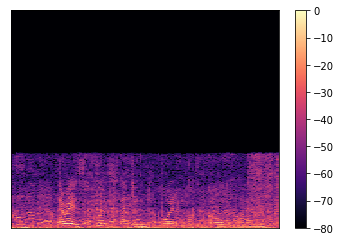

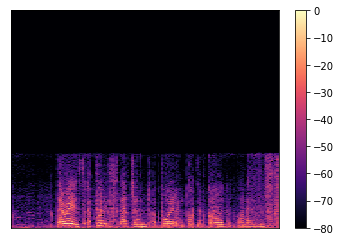

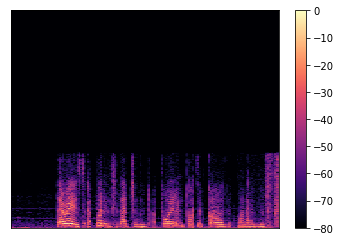

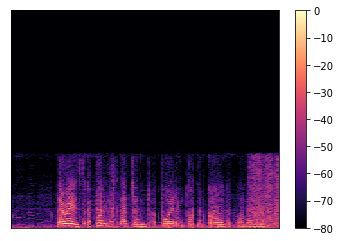

In [6]:
## Niose
import librosa.display
S_db = librosa.amplitude_to_db(np.abs(read_as_spectrogram("content/MyDrive/speech_test/p257_009.wav")[0]), ref=np.max)
plt.figure()
#DFN
img1 = librosa.display.specshow(S_db)
plt.colorbar()
S_db = librosa.amplitude_to_db(np.abs(read_as_spectrogram("content/MyDrive/test_clean_results/p257_009.wav")[0]), ref=np.max)
plt.figure()
#WGAN
img2 = librosa.display.specshow(S_db)
plt.colorbar()
S_db = librosa.amplitude_to_db(np.abs(read_as_spectrogram("content/MyDrive/p257_009.wav")[0]), ref=np.max)
plt.figure()
img3 = librosa.display.specshow(S_db)
plt.colorbar()
#SEGAN
S_db = librosa.amplitude_to_db(np.abs(read_as_spectrogram("content/MyDrive/seganp257_009.wav")[0]), ref=np.max)
plt.figure()
img4= librosa.display.specshow(S_db)
plt.colorbar()

      3.556902408599853516e-01
0                     0.464218
1                     0.441260
2                     0.559785
3                     0.618402
4                     0.466439
...                        ...
1944                  0.148799
1945                  0.401841
1946                  0.140928
1947                  0.373240
1948                  0.168442

[1949 rows x 1 columns]


Text(0.5, 1.0, 'Generative Loss')

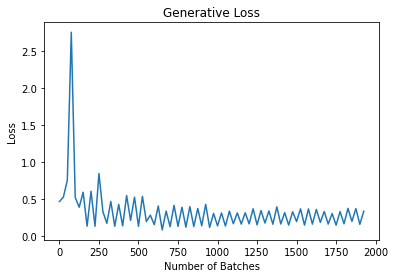

In [ ]:
import pandas as pd
df = pd.read_csv('content/MyDrive/segan_results_music/g_adv_losses.txt')
print(df)
plt.plot([i for i in range(0, len(df), 25)], df[::25])
plt.ylabel("Loss")
plt.xlabel("Number of Batches")
plt.title("Generative Loss")